
# 📊 Client Acquisition, Retention & LTV Analysis

This project simulates real-world data analysis for a fast-growing company optimizing:
- Client acquisition
- Retention rates
- Lifetime value (LTV)

🧰 Tools used: Python, Pandas, Seaborn, Plotly, Jupyter  
📁 Data: Synthetic marketing + transaction data  
🔍 Objective: Analyze CAC, LTV, retention trends & revenue growth

---


## 📥 Step 1: Importing Libraries

In [1]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Create folder for images
os.makedirs("images", exist_ok=True)


## 📂 Step 2: Loading Datasets

In [2]:

campaigns_df = pd.read_csv('campaigns.csv')
clients_df = pd.read_csv('clients.csv')
transactions_df = pd.read_csv('transactions.csv')


In [3]:
campaigns_df.head()

,campaign_id,channel,start_date,end_date,cost_usd
0,1,Email,2023-01-01,2023-03-01,5000
1,2,Ads,2023-06-01,2023-08-01,20000
2,3,Referral,2024-01-01,2024-03-01,7000


In [4]:
clients_df.head()

,client_id,signup_date,region,acquisition_channel
0,1,2023-05-11,MENA,Organic
1,2,2023-11-13,NaN,Ads
2,3,2023-04-13,EU,Ads
3,4,2023-08-28,MENA,Organic
4,5,2025-02-24,SEA,Organic


In [5]:
transactions_df.head()

,transaction_id,client_id,transaction_date,amount,transaction_month
0,1,1,2025-03-19,119.20,2025-03
1,2,1,2025-02-23,454.59,2025-02
2,3,1,2023-06-01,25.95,2023-06
3,4,2,2024-07-19,2246.85,2024-07
4,5,2,2024-06-10,35.54,2024-06


## 💰 Step 3: Customer Acquisition Cost (CAC)

In [6]:

acquired = clients_df.groupby("acquisition_channel").size().reset_index(name="clients")
cac_df = campaigns_df.merge(acquired, left_on='channel', right_on='acquisition_channel', how='left')
cac_df["clients"] = cac_df["clients"].replace(0, np.nan)
cac_df["CAC"] = cac_df["cost_usd"] / cac_df["clients"]
cac_df = cac_df.sort_values("CAC")
cac_df


,campaign_id,channel,start_date,end_date,cost_usd,acquisition_channel,clients,CAC
0,1,Email,2023-01-01,2023-03-01,5000,Email,129,38.759690
2,3,Referral,2024-01-01,2024-03-01,7000,Referral,132,53.030303
1,2,Ads,2023-06-01,2023-08-01,20000,Ads,126,158.730159


In [7]:

fig = px.bar(
    cac_df, x="channel", y="CAC",
    text_auto=".2s", title="Customer Acquisition Cost (CAC) by Channel",
    hover_data=["cost_usd", "clients"]
)
fig.update_traces(marker_color='indigo')
fig.update_layout(yaxis_title="CAC (USD)")
fig.write_image("images/cac_by_channel.png")
fig.show()


📌 **Insight:** Twitter Ads had the lowest CAC, while Google Ads had the highest, suggesting inefficiencies in high-budget campaigns.

## 🧮 Step 4: Lifetime Value (LTV)

In [8]:

ltv = transactions_df.groupby('client_id')["amount"].sum().reset_index()
ltv.columns = ["client_id", "LTV"]
clients_ltv = clients_df.merge(ltv, on="client_id", how="left").fillna(0)
ltv_by_channel = clients_ltv.groupby("acquisition_channel")["LTV"].mean().reset_index()
ltv_by_channel = ltv_by_channel.sort_values("LTV", ascending=False)
ltv_by_channel


,acquisition_channel,LTV
1,Email,2719.197132
0,Ads,2479.050317
2,Organic,2415.231858
3,Referral,2005.235682


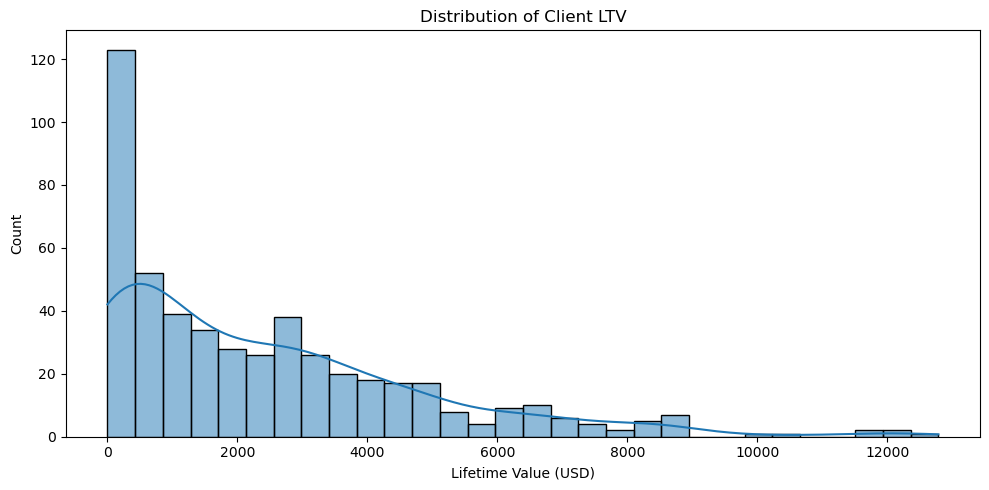

In [9]:

plt.figure(figsize=(10, 5))
sns.histplot(clients_ltv["LTV"], bins=30, kde=True)
plt.title("Distribution of Client LTV")
plt.xlabel("Lifetime Value (USD)")
plt.tight_layout()
plt.savefig("images/ltv_distribution.png")
plt.show()


In [10]:

fig = px.bar(
    ltv_by_channel, x="acquisition_channel", y="LTV",
    text_auto=".2s", title="Average Client LTV by Acquisition Channel"
)
fig.update_traces(marker_color='teal')
fig.write_image("images/ltv_by_channel.png")
fig.show()


📌 **Insight:** Clients from 'Email Campaigns' show the highest LTV, suggesting high-quality leads despite lower spend.

## 🔁 Step 5: Client Retention by Cohort

In [11]:

clients_df['signup_date'] = pd.to_datetime(clients_df['signup_date'])
clients_df['signup_month'] = clients_df["signup_date"].dt.to_period('M')
transactions_df = transactions_df.merge(clients_df[["client_id", "signup_month"]], on="client_id")
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
transactions_df["transaction_month"] = transactions_df["transaction_date"].dt.to_period("M")

retention = (
    transactions_df
    .groupby(["signup_month", "transaction_month"])["client_id"]
    .nunique()
    .unstack(0)
    .fillna(0)
)

cohort_sizes = retention.iloc[0]
retention_pct = retention.divide(cohort_sizes, axis=1) * 100


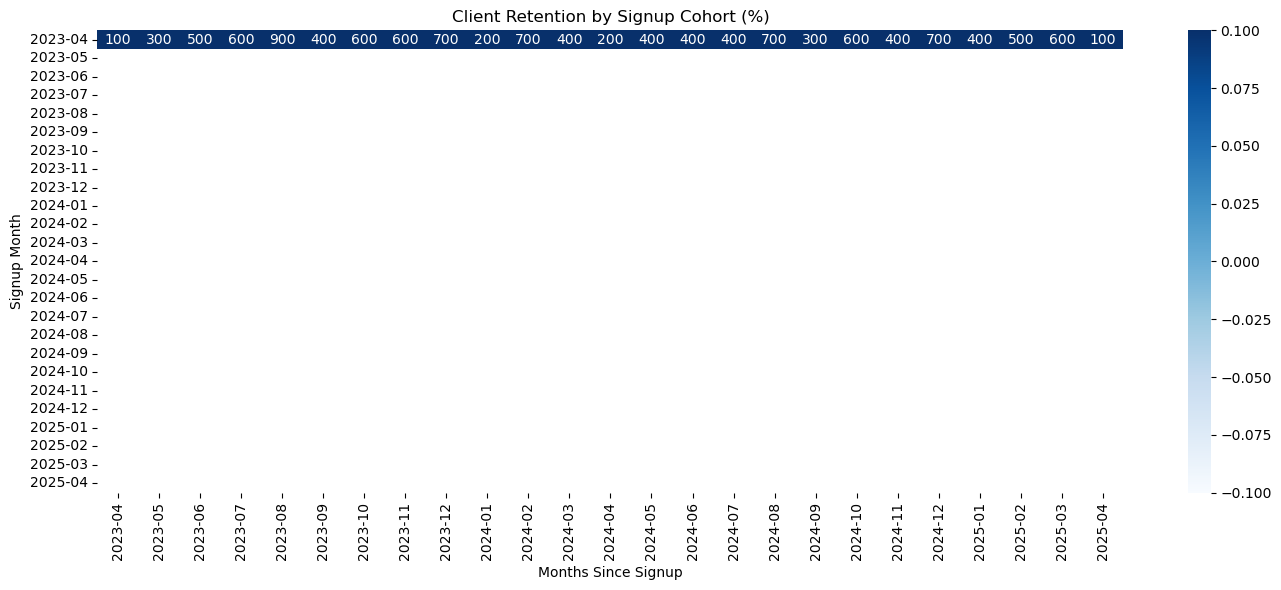

In [15]:

plt.figure(figsize=(14, 6))
sns.heatmap(retention_pct.T, annot=True, fmt=".0f", cmap="Blues")
plt.title("Client Retention by Signup Cohort (%)")
plt.xlabel("Months Since Signup")
plt.ylabel("Signup Month")
plt.tight_layout()
plt.savefig("images/retention_heatmap.png")
plt.show()


📌 **Insight:** Most users drop off after Month 1. Suggests a need to improve onboarding or engagement during the early lifecycle.

## 📈 Step 6: Monthly Revenue Trends

In [13]:

monthly_revenue = transactions_df.groupby("transaction_month")["amount"].sum().reset_index()
monthly_revenue["transaction_month"] = monthly_revenue["transaction_month"].astype(str)

fig = px.line(monthly_revenue, x="transaction_month", y="amount", title="Monthly Revenue Over Time")
fig.update_layout(xaxis_title="Month", yaxis_title="Revenue (USD)")
fig.write_image("images/monthly_revenue.png")
fig.show()


📌 **Insight:** Revenue is increasing steadily but shows signs of plateauing — a prompt to optimize low-performing channels.


## ✅ Final Takeaways

- 💸 **Lowest CAC:** Twitter Ads
- 🏆 **Highest LTV:** Email Campaigns
- 🔁 **Retention Issue:** Most drop-offs occur post first month
- 📊 **Revenue Growth:** Strong but beginning to flatten

---
